In [ ]:
!gdown 1zRHT9eSFUNK6o3AHwQmyAeFzXfEzkEts
!unzip vqa_coco_dataset.zip -d /content/vqa_coco_dataset

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U sentencepiece
!pip install git+https://github.com/huggingface/transformers

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from transformers.utils.dummy_sentencepiece_objects import LlamaTokenizer
from transformers import LlavaForConditionalGeneration, AutoProcessor, BitsAndBytesConfig, GenerationConfig

## Load Dataset

In [6]:
def load_data(data_path):
    data = []
    with open(data_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split("\t")
            qa = temp[1].split("?")

            # Extract the answer depending on the length of the split qa list
            answer = qa[2].strip() if len(qa) == 3 else qa[1].strip()

            # Clean the image path by removing the last two characters '#0'
            image_path = temp[0][:-2]

            data.append({
                "image_path": image_path,
                "question": qa[0] + "?",
                "answer": answer
            })
    return data

In [10]:
train_path = "/content/vqa_coco_dataset/vaq2.0.TrainImages.txt"
val_path = "/content/vqa_coco_dataset/vaq2.0.DevImages.txt"
test_path = "/content/vqa_coco_dataset/vaq2.0.TestImages.txt"

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

len(train_data), len(val_data), len(test_data)

(7846, 1952, 2022)

## LLaVA

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure 4-bit quantization for efficient memory and computation
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# Model and processor setup
model_id = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(model_id)

# Load model with quantization and map to the selected device
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Prompt

In [7]:
def create_prompt(question):
    """ Creates a formatted prompt for the model."""
    prompt = f"""### INSTRUCTION:
                Your task is to answer the question based on the given image. You can
                only answer 'yes' or 'no'.

                ### USER: <image>
                {question}

                ### ASSISTANT:
            """
    return prompt

## Inference

In [8]:
# Configure generation settings
generation_config = GenerationConfig(
    max_new_tokens=10, # Maximum number of new tokens to generate
    do_sample=True, # Enable sampling for diverse outputs
    temperature=0.1, # Control randomness; lower values make output more deterministic
    top_p=0.95, # Use nucleus sampling (keep top 95% of probability mass)
    top_k=50, # Limit sampling to top 50 tokens by probability
    eos_token_id=model.config.eos_token_id, # End-of-sequence token ID
    pad_token_id=model.config.eos_token_id # Padding token ID for alignment
)

In [13]:
idx = 0

image_name = test_data[idx]["image_path"]
image_path = os.path.join("/content/vqa_coco_dataset/val2014-resised", image_name)
image = Image.open(image_path)

question = test_data[idx]["question"]

answer = test_data[idx]["answer"]

image_path, question, answer

('/content/vqa_coco_dataset/val2014-resised/COCO_val2014_000000262162.jpg',
 'Are there any boxes in the room ?',
 'no')

In [14]:
# Create a formatted prompt from the question
prompt = create_prompt(question)

# Process image and prompt
inputs = processor(image, prompt, padding=True, return_tensors="pt").to(device)

# Generate model output
output = model.generate(**inputs, generation_config=generation_config)

# Decode the output
generated_text = processor.decode(output[0], skip_special_tokens=True)

# Extract the prediction
prediction = generated_text.split("ASSISTANT:")[1].strip()

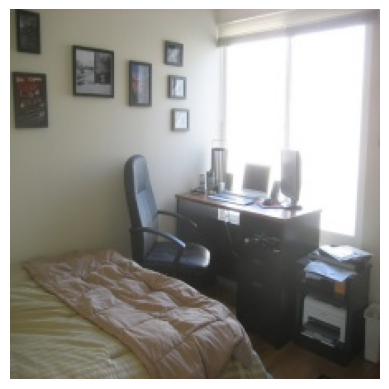

Question: Are there any boxes in the room ?
Answer: no
Prediction: No


In [16]:
plt.imshow(image)
plt.axis("off")
plt.show()

print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Prediction: {prediction}")